#Table of Contents
* [1. Tratamento das variáveis estruturais](#1.-Tratamento-das-variáveis-estruturais)
* [2. Variáveis Longitude e Latitude](#2.-Variáveis-Longitude-e-Latitude)
* [3. Verificar e remover outliers.](#3.-Verificar-e-remover-outliers.)
	* [3.1 Variável 'quartos'](#3.1-Variável-'quartos')
	* [3.2 Característica 'area'](#3.2-Característica-'area')
	* [3.3 Característica 'garagem'](#3.3-Característica-'garagem')
	* [3.4 Característica 'suites'](#3.4-Característica-'suites')
	* [3.5 Característica 'm2'](#3.5-Característica-'m2')
	* [3.6 Variável 'preço'](#3.6-Variável-'preço')
* [4. Salvar ids dos imóveis resultantes do filtro de outlier.](#4.-Salvar-ids-dos-imóveis-resultantes-do-filtro-de-outlier.)


# 1. Tratamento das variáveis estruturais

Vamos verificar como estão os dados. Primeiro, a view vw_imovel_rio seleciona apenas os imóveis geograficamente na cidade do Rio de Janerio, logo já elimina os imóveis que não possuem latitude e longitude.

In [1]:
%pylab inline



import zap_util as z
from scipy.stats import zscore


z.set_style()


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Selecionar do banco somente imóveis da cidade do 
df = z.get('select id,area,preco_ajustado as preco,m2_ajustado as m2,'+
    'garagem,quartos,suites,condominio,lng,lat ' + 
    ' from vw_imovel_rio inner join preco_ajustado p using (id)')

df.describe()

,area,preco,m2,garagem,quartos,suites,condominio,lng,lat
count,59412.000000,59412.000000,59412.000000,47713.000000,59369.000000,36839.000000,51841.000000,59412.000000,59412.000000
mean,123.551404,1389.054776,10.288691,2.446796,2.632889,1.435354,22.429195,-43.284459,-22.952593
std,105.676316,3269.934734,6.489658,41.535622,1.447283,1.145904,4392.359266,0.097964,0.045369
min,15.000000,45.000000,0.383259,1.000000,1.000000,1.000000,0.001000,-43.721668,-23.066667
25%,70.000000,495.000000,6.041503,1.000000,2.000000,1.000000,0.410000,-43.357212,-22.985393
50%,92.000000,840.318168,8.606557,1.000000,3.000000,1.000000,0.650000,-43.248444,-22.956712
75%,144.000000,1579.719066,12.500000,2.000000,3.000000,2.000000,1.000000,-43.197077,-22.923000
max,12930.000000,653123.640000,320.619343,2011.000000,234.000000,150.000000,1000000.000000,-43.157761,-22.786389


Temos mais de 59000 registros. Vejamos quais informações numéricas estão faltando.

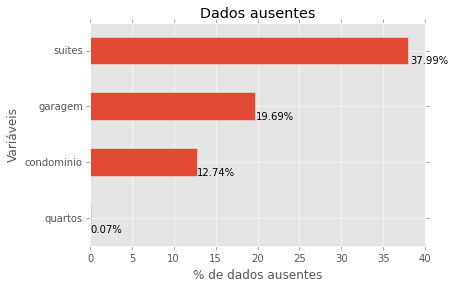

In [3]:

miss = df.isnull().sum()
miss = miss[miss > 0] # Somente os que não possuem dados.
miss = miss / len(df) * 100 # Percentual
miss.sort()
ax = miss.plot(kind='barh', title='Dados ausentes');
xlabel('% de dados ausentes');
ylabel (u'Variáveis');
for p in ax.patches:
    ax.annotate(str(p.get_width().round(2))+'%', xy=(p.get_width() * 1.01, p.get_y() * 1.005), );
    
savefig('./../texto/img/var_intrins_ausente.png')


Trataremos as característica ausentes conforme seu tipo. Valores numéricos serão definidos como 0, e valores categóricos conforme o contexto.

In [4]:
# Remover os imóveis que não tiveram detalhes obtidos. São doze no total.

# Remover imóveis sem quartos.
df = df[~df.quartos.isnull()]


df.condominio.fillna(value=0,inplace=True)
df.garagem.fillna(value=0, inplace=True)
df.suites.fillna(value=0, inplace=True)

# Verificar quais variáveis ainda estão nulas.
df.isnull().sum()

area          0
preco         0
m2            0
garagem       0
quartos       0
suites        0
condominio    0
lng           0
lat           0
dtype: int64

# 2. Variáveis Longitude e Latitude

As variáveis longitude e latitude, que permitem a geolocalização do imóvel, não são estruturais e sim auxiliares para a determinação das variáveis de acessbilidade. Entretanto, decidimos tratá-las logo para encontrar imóveis com localizações repetidas.

In [5]:
antes = len(df)
lat_antes = df.lat.copy()
lng_antes = df.lng.copy()

In [6]:
# Verificar distribuição das coordenadas repetidas.
g = df.groupby(['lng','lat'])
g.size().describe()

count    21830.000000
mean         2.719606
std         11.262730
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1108.000000
dtype: float64

In [7]:
# Iremos filtrar nosso dataset permitindo até 5 repetições (75%).
latlng = g.size()[g.size()<=5].index.tolist()
index_sel = []
for k in latlng:
    index_sel.extend(g.groups[k])
df = df.loc[index_sel]

In [8]:
depois = len(df)

print "Antes: {}. Depois: {}. Excluídos:{}".format(antes,depois,antes-depois)

Antes: 59369. Depois: 31090. Excluídos:28279


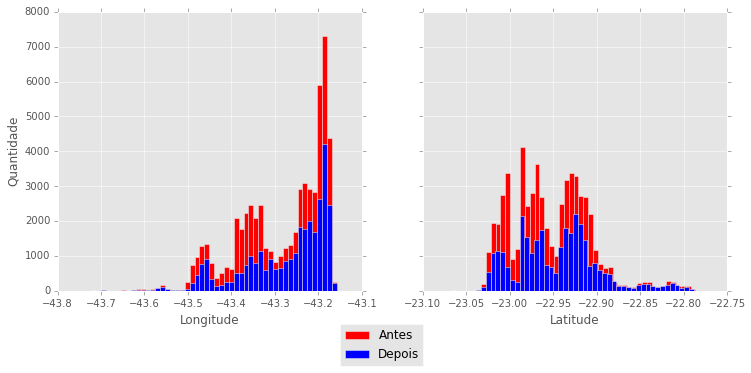

In [9]:
bins=50;
f,(a1,a2) = subplots(1,2,sharey=True)
f.set_size_inches(12,5)
a1.hist(lng_antes,color='r',bins=bins,label='Antes');
a1.hist(df.lng,color='b',bins=bins, label='Depois');
a2.hist(lat_antes,color='r',bins=bins,label='Antes');
a2.hist(df.lat,color='b',bins=bins, label='Depois');
a1.set_ylabel('Quantidade');
a1.set_xlabel('Longitude');
a2.set_xlabel('Latitude');
lgd= legend( loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure );

f.savefig('./../texto/img/var_latlng_antes_depois.png', 
    bbox_extra_artists=(lgd,), bbox_inches='tight')

# 3. Verificar e remover outliers.

Usaremos a quantidade em desvios padrão em conjunto com histogramas e boxplot para identificar e remover os outliers que definimeros como aqueles acima de 3 desvios padrões.

## 3.1 Variável 'quartos'

Representa a quantidade de quartos no imóvel.

In [10]:
print 'Total de registros: {}'.format(len(df))
antes = len(df)

Total de registros: 31090


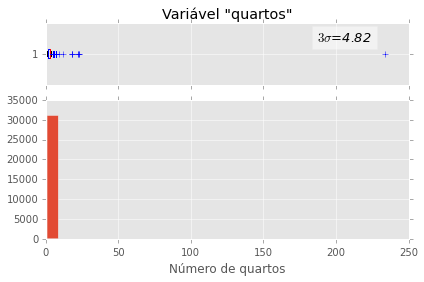

In [11]:
reload(z)
z.plot_boxhist(df.quartos, u'Variável "quartos"', u'Número de quartos')
savefig('./../texto/img/var_quartos_boxhist_antes.png')

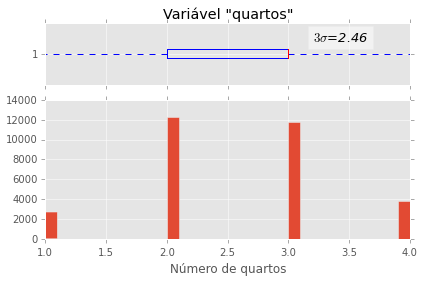

In [12]:
# Determinamos arbitrariamente o limite de quartos de interesse no estudo.
limite = 4
df2 = df[df.quartos <= limite]
z.plot_boxhist(df2.quartos, u'Variável "quartos"', u'Número de quartos')
savefig('./../texto/img/var_quartos_boxhist_depois.png')


In [13]:

depois = len(df2)
print "Depois:{}. Excluídos:{}".format(depois,antes-depois)

Depois:30547. Excluídos:543


In [14]:
df = df2

## 3.2 Característica 'area'

Representa a área do imóvel em metros quadrados, $m^2$.

Com base na reportagem http://g1.globo.com/economia/noticia/2014/09/rio-continua-com-o-metro-quadrado-mais-caro-do-pais-aponta-fipezap.html do jornal O Globo de 4 de setembro de 2013, mostra que o valor médio do metro quadrado mais caro da cidade é de R\$ 23.613, limitamos os valores de $ m^2 $ ao máximod de R\$ 30.000,00.

In [15]:
antes = len(df)


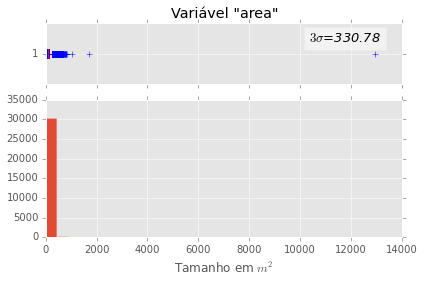

In [16]:
z.plot_boxhist(df.area, u'Variável "area"', 'Tamanho em $m^2$')
savefig('./../texto/img/var_area_boxhist_antes.png')

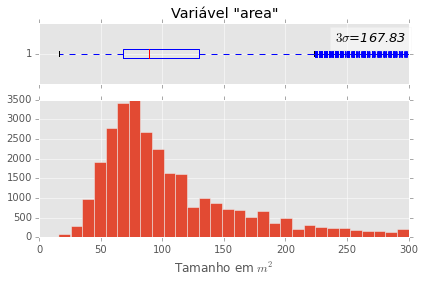

In [17]:
# Remover imóveis acima de 300 m2.
limite = 300
df2 = df[df.area <= limite]
z.plot_boxhist(df2.area, u'Variável "area"', 'Tamanho em $m^2$')
savefig('./../texto/img/var_area_boxhist_depois.png')


In [18]:
depois = len(df2)

print "Antes: {}. Depois: {}. Excluídos:{}".format(antes,depois,antes-depois)

Antes: 30547. Depois: 29327. Excluídos:1220


In [19]:
df = df2

## 3.3 Característica 'garagem'

Representa a quantidade de vagas de garagem pertencentes ao imóvel.

In [20]:
antes = len(df)

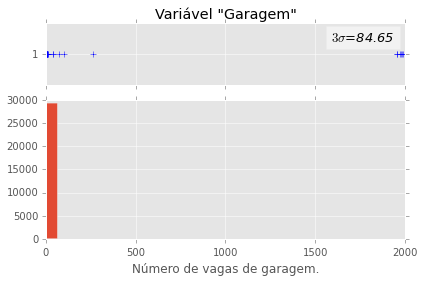

In [21]:
z.plot_boxhist(df.garagem, u'Variável "Garagem"', u'Número de vagas de garagem.')
savefig('./../texto/img/var_garagem_boxhist_antes.png')

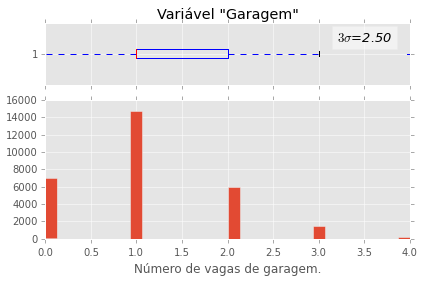

In [22]:
limite = 4
df2 = df[df.garagem<=limite]
z.plot_boxhist(df2.garagem, u'Variável "Garagem"', u'Número de vagas de garagem.')
savefig('./../texto/img/var_garagem_boxhist_depois.png')


In [23]:
depois = len(df2)

print "Antes: {}. Depois: {}. Excluídos:{}".format(antes,depois,antes-depois)

Antes: 29327. Depois: 29296. Excluídos:31


In [24]:
df = df2

## 3.4 Característica 'suites'

Representa a quantidade de suítes, quartos com banheiro próprio.

Verificamos não existirem outliers.

In [25]:
antes = len(df)

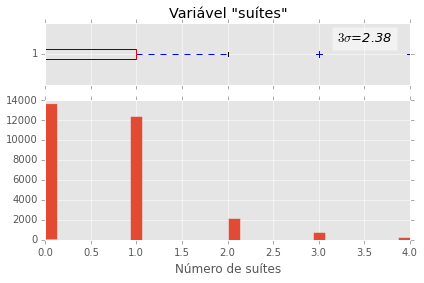

In [26]:
z.plot_boxhist(df.suites, u'Variável "suítes"', u'Número de suítes')
savefig('./../texto/img/var_suites_boxhist_antes.png')

In [27]:
depois = len(df2)

print "Antes: {}. Depois: {}. Excluídos:{}".format(antes,depois,antes-depois)

Antes: 29296. Depois: 29296. Excluídos:0


## 3.5 Característica 'm2'

Representa o valor do metro quadrado.

Reportagem do Globo em setembro de 2014 mostra metro quadrado médio por bairro mais caro é inferior a 25000.

http://g1.globo.com/economia/noticia/2014/09/rio-continua-com-o-metro-quadrado-mais-caro-do-pais-aponta-fipezap.html

In [28]:
antes = len(df)

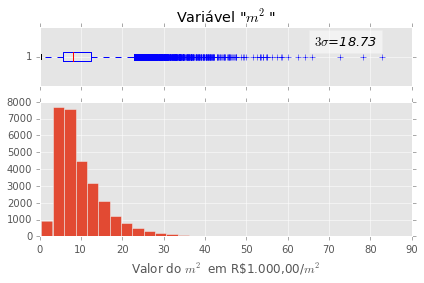

In [29]:

z.plot_boxhist(df.m2, u'Variável "$m^2$"' , 'Valor do $m^2$ em R\$1.000,00/$m^2$')
savefig('./../texto/img/var_m2_boxhist_antes.png')

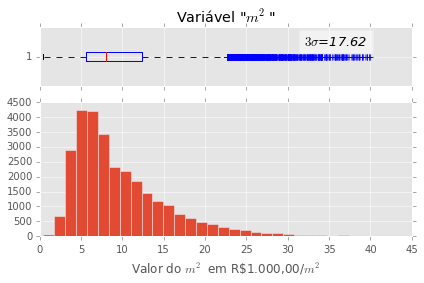

In [30]:
# Com base na reportagem, definimos o limite de R$ 40 mil/m2.
limite = 40

df2 = df[df.m2 <= limite]

z.plot_boxhist(df2.m2, u'Variável "$m^2$"' , 'Valor do $m^2$ em R\$1.000,00/$m^2$')
savefig('./../texto/img/var_m2_boxhist_depois.png')


In [31]:
depois = len(df2)

print "Antes: {}. Depois: {}. Excluídos:{}".format(antes,depois,antes-depois)

Antes: 29296. Depois: 29204. Excluídos:92


In [32]:
df = df2

## 3.6 Variável 'preço'

In [33]:
antes = len(df)

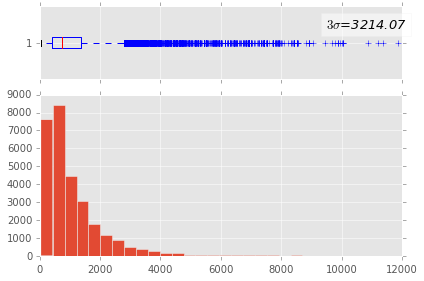

In [34]:
z.plot_boxhist(df.preco)
savefig('./../texto/img/var_preco_boxhist_antes.png')

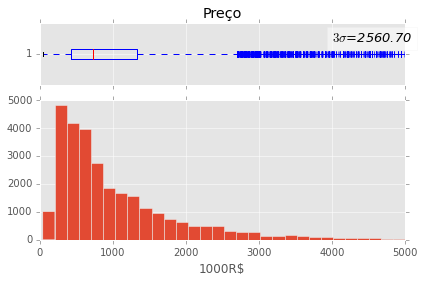

In [35]:
df2 = df[df.preco <= 5000]
z.plot_boxhist(df2.preco, u'Preço', u'1000R\$');
savefig('./../texto/img/var_preco_boxhist_depois.png')

In [36]:
depois = len(df2)

print "Antes: {}. Depois: {}. Excluídos:{}".format(antes,depois,antes-depois)

Antes: 29204. Depois: 28819. Excluídos:385


In [37]:
df = df2

# 4. Salvar ids dos imóveis resultantes do filtro de outlier.

Presumimos que o conjunto de dados esteja livre de ouliers. Desta forma iremos salvar os ids dos imóveis selecionados para utlização futura.

In [38]:
# Salvar ids selecionados no banco de dados, usando copy_from 
# para inserir uma grande quantidade de dados.
# A instrução condicional 'if' serve apenas para não executar
# esse procedimento por acidente.
if False:
    z.exec_sql('delete from imovel_sel ')
    f = open('./imovel_sel.txt', 'w')
    df.to_csv(f,index=True,columns=[],sep="\t")
    f.close()
    f = open('./imovel_sel.txt', 'r')
    con = z.d.conecta_db()
    con.cursor().copy_from(f, 'imovel_sel',columns=['id'])
    con.commit()
    f.close()
    z.exec_sql('refresh materialized view vw_imovel')